In [75]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Activation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.decomposition import PCA

In [76]:
path = "F:\JupyterNotebook_Dir\REAM _Lab\OPF\SUMMARY TABLE\Inverter_Ouput_Gen_4.xlsx"
df = pd.read_excel(path)       #read data

q_inverter = df["q_inverter"].values;
p_demand = df["net_p_demand"].values      #access columns
q_consumption = df["q_consumption"].values;
q_capacity = df["q_capacity"].values;
p_x_q = df["p_x_q"].values
p_x_p = df["p_x_p"].values
p_x_q_capacity = df["p_x_q_capacity"].values;
voltage = df["voltage"].values;



data_output = q_inverter

data_input = np.vstack((p_demand,q_consumption,q_capacity,p_x_q,p_x_p,p_x_q_capacity,voltage)).T

In [77]:
print(data_input.shape)
print(data_output)

(2400, 7)
[1.01674266 0.96960554 0.8726523  ... 1.30365752 2.04694708 1.44945981]


In [78]:
def rnn_model(seq_length, input_dim):
    model = Sequential()
#     model.add(tf.keras.layers.LSTM(128, input_shape= (seq_length, input_dim), return_sequences=False))
    model.add((SimpleRNN(60, input_shape=(seq_length, input_dim))))
#     model.add(Activation('relu'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))
    
    model.add(Dense(60))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [79]:
scaler_input = StandardScaler()
scaler_output = StandardScaler()

datas_scaled = scaler_input.fit_transform(data_input)
features = datas_scaled

data_output = data_output.reshape(-1,1)
target = scaler_output.fit_transform(data_output)
target = target.reshape(-1,1)


x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123, shuffle=False)
x_train.shape
win_length = 20
batch_size = 500
num_features = 7
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [80]:
model = rnn_model(seq_length = win_length, input_dim = num_features)
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit_generator(train_generator, epochs=100, validation_data=test_generator, shuffle=False)

Epoch 1/100
4/4 [==============================] - 0s 60ms/step - loss: 0.4020 - mean_absolute_error: 0.4008 - val_loss: 3.8923 - val_mean_absolute_error: 1.5551
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.3446 - mean_absolute_error: 0.3009 - val_loss: 4.1303 - val_mean_absolute_error: 1.6231
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.3333 - mean_absolute_error: 0.2823 - val_loss: 4.1674 - val_mean_absolute_error: 1.6364
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.3207 - mean_absolute_error: 0.2738 - val_loss: 4.0741 - val_mean_absolute_error: 1.6118
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.3137 - mean_absolute_error: 0.2709 - val_loss: 3.9884 - val_mean_absolute_error: 1.5898
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 0.3048 - mean_absolute_error: 0.2740 - val_loss: 3.9888 - val_mean_absolute_error: 1.5931
Epoch 7/100
4/4 [===========

4/4 [==============================] - 0s 14ms/step - loss: 0.2067 - mean_absolute_error: 0.2324 - val_loss: 4.3499 - val_mean_absolute_error: 1.6851
Epoch 52/100
4/4 [==============================] - 0s 16ms/step - loss: 0.1919 - mean_absolute_error: 0.2259 - val_loss: 4.0957 - val_mean_absolute_error: 1.6208
Epoch 53/100
4/4 [==============================] - 0s 14ms/step - loss: 0.2127 - mean_absolute_error: 0.2365 - val_loss: 4.2126 - val_mean_absolute_error: 1.6445
Epoch 54/100
4/4 [==============================] - 0s 14ms/step - loss: 0.1732 - mean_absolute_error: 0.2130 - val_loss: 4.1680 - val_mean_absolute_error: 1.6346
Epoch 55/100
4/4 [==============================] - 0s 13ms/step - loss: 0.1721 - mean_absolute_error: 0.2205 - val_loss: 4.1347 - val_mean_absolute_error: 1.6299
Epoch 56/100
4/4 [==============================] - 0s 15ms/step - loss: 0.1821 - mean_absolute_error: 0.2178 - val_loss: 4.2676 - val_mean_absolute_error: 1.6623
Epoch 57/100
4/4 [=================

In [81]:
# model.evaluate_generator(test_generator, verbose=0)
predictions = model.predict_generator(train_generator)
print(predictions.shape)
# rev_trans = scaler_input.inverse_transform(datas_pred)
rev_trans = scaler_output.inverse_transform(predictions)
print(rev_trans.shape)

(1900, 1)
(1900, 1)


In [82]:
print(rev_trans.shape)
print(rev_trans[:,-1])

(1900, 1)
[ 1.4006308  1.3372234  1.6097528 ... 17.4938    13.919752  11.476383 ]


<ipython-input-83-669839c0b6b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas_final['Predicted control'] = rev_trans[:,-1]


<AxesSubplot:>

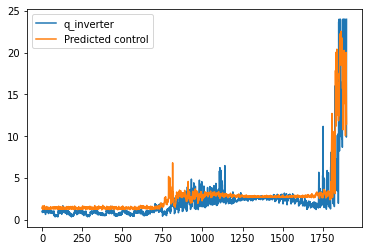

In [83]:
datas_final = df[:predictions.shape[0]]
datas_final.count()
datas_final['Predicted control'] = rev_trans[:,-1]
datas_final[['q_inverter','Predicted control']].plot()

Text(0.5, 1.0, 'Loss')

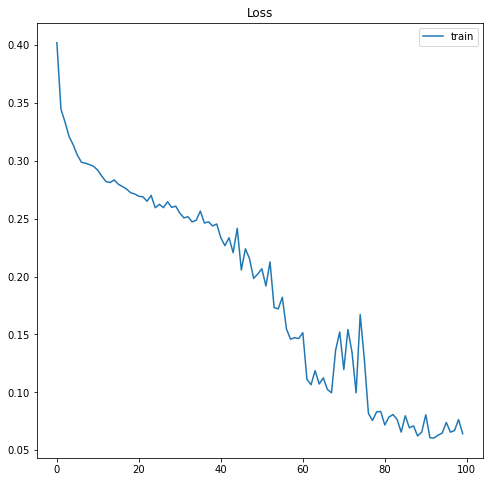

In [84]:
epoch = len(history.history['val_mean_absolute_error'])
epoch = np.arange(epoch)

plt.figure(figsize=(8,8))
# plt.subplot(1,2,1)
# # plt.plot(epoch,history.history['accuracy'])
# plt.plot(epoch,history.history['val_loss'])
# plt.title('Val_Loss')
# plt.legend(labels=['train', 'val'],  loc='lower right')


#Plot loss vs epoch
# plt.subplot(1,2,2)
plt.plot(epoch,history.history['loss'])
plt.legend(labels=['train', 'val'],  loc='upper right')
plt.title('Loss')

# FGSM attack

In [85]:
data_test = np.concatenate((train_generator[0][0],train_generator[1][0],train_generator[2][0],train_generator[3][0]),axis=0)
data_test = tf.convert_to_tensor(data_test)
target_test = np.concatenate((train_generator[0][1],train_generator[1][1],train_generator[2][1],train_generator[3][1]),axis=0)
y_actual = target_test.reshape(-1,1)
y_actual = tf.convert_to_tensor(y_actual)

print(data_test.shape)
print(y_actual.shape)
print(type(data_test))
print(type(y_actual))

(1900, 20, 7)
(1900, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [86]:

with tf.GradientTape() as tape:
    data_test = tf.cast(data_test,dtype='float64')
    tape.watch(data_test)
    yy = model(data_test)
    
    yy = tf.cast(yy,dtype='float64')
    loss = tf.square(yy - y_actual)
#     loss = loss.astype('float32')
grad = tape.gradient(loss, data_test)

sign_grad = tf.sign(grad)

In [87]:
sign_grad.shape

TensorShape([1900, 20, 7])

In [88]:
levels = [0.01,0.05,0.1,0.11,0.12]

MAPE_FGSM = []
r2Score_FGSM = []
pert_level = []


for level in levels:
    x_adv = data_test + level*sign_grad
    y_adv = model(x_adv)
    y_adv = scaler_output.inverse_transform(y_adv)
    
    pert = mean_absolute_percentage_error(tf.reshape(x_adv,(-1,1)),tf.reshape(data_test,(-1,1)))/10
    pert_level.append(pert*200)

    epsilon = mean_absolute_percentage_error(datas_final['q_inverter'].values,y_adv)*25
    score_FGSM = r2_score(datas_final[['q_inverter']].values,y_adv)
    MAPE_FGSM.append(epsilon)
    r2Score_FGSM.append(MAPE_FGSM)

In [89]:
print(MAPE_FGSM)
print(pert_level)

[14.928341417848667, 17.730941261366056, 23.38624084378403, 24.61611009837507, 25.951786241707676]
[1.0581417088536753, 6.310836287677421, 9.572504489162554, 10.822109962173302, 15.508393007196847]


Text(0.5, 1.0, 'Fast Gradient Sign Method')

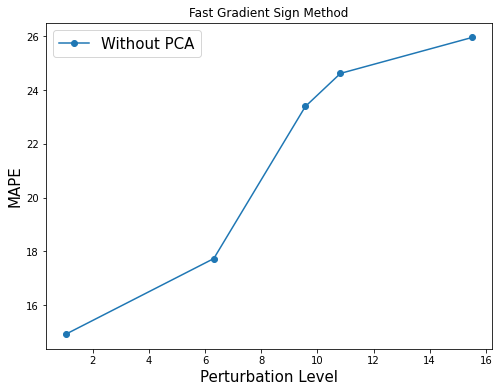

In [90]:
plt.figure(figsize=(8,6))
plt.plot(pert_level, MAPE_FGSM, label="Without PCA",marker='o');
# plt.plot(levels, MAPE_pca_FGSM, label="With PCA",marker='o');
plt.xlabel("Perturbation Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Fast Gradient Sign Method")

# PCA defense against FGSM attack

In [91]:
# generating PCA data
def generating_PCAdata(x,n):
    pca = PCA(n_components=n)
    x_pca = pca.fit_transform(x)
    return x_pca


def reorganize(x,n):
    n0 =x.shape[0]
    n1 =x.shape[1]
    n2 =x.shape[2]
    
    x_re = np.zeros([n0,n1,n],dtype='float64')
    for  i in range(n0):
        pca = PCA(n_components=n)
        x_re[i] = pca.fit_transform(x[i])
    
    return x_re 

In [92]:
n_PCA = 5 #number of PCA features


datas_pca = generating_PCAdata(datas_scaled,n_PCA)
features_pca = datas_pca



x_train, x_test, y_train, y_test = train_test_split(features_pca, target, test_size=0.2, random_state=123, shuffle=False)

win_length = 20
batch_size = 500
# num_features = n_PCA
train_generator_pca = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator_pca = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [93]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1920, 5)
(1920, 1)
(480, 5)
(480, 1)


In [94]:
model_pca = rnn_model(seq_length = win_length, input_dim = n_PCA)
model_pca.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history_pca = model_pca.fit_generator(train_generator_pca, epochs=100, validation_data=test_generator_pca, shuffle=False)

Epoch 1/100
4/4 [==============================] - 0s 117ms/step - loss: 0.4880 - mean_absolute_error: 0.4830 - val_loss: 4.1976 - val_mean_absolute_error: 1.6366
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.3959 - mean_absolute_error: 0.3667 - val_loss: 4.3796 - val_mean_absolute_error: 1.6903
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.3693 - mean_absolute_error: 0.3387 - val_loss: 4.2142 - val_mean_absolute_error: 1.6462
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.3439 - mean_absolute_error: 0.3233 - val_loss: 4.0556 - val_mean_absolute_error: 1.6026
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.3353 - mean_absolute_error: 0.3210 - val_loss: 3.9851 - val_mean_absolute_error: 1.5842
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.3230 - mean_absolute_error: 0.3148 - val_loss: 3.9948 - val_mean_absolute_error: 1.5897
Epoch 7/100
4/4 [==========

4/4 [==============================] - 0s 14ms/step - loss: 0.1488 - mean_absolute_error: 0.2075 - val_loss: 4.0178 - val_mean_absolute_error: 1.6105
Epoch 52/100
4/4 [==============================] - 0s 14ms/step - loss: 0.1241 - mean_absolute_error: 0.1952 - val_loss: 3.8110 - val_mean_absolute_error: 1.5629
Epoch 53/100
4/4 [==============================] - 0s 14ms/step - loss: 0.1323 - mean_absolute_error: 0.2085 - val_loss: 3.8751 - val_mean_absolute_error: 1.5787
Epoch 54/100
4/4 [==============================] - 0s 14ms/step - loss: 0.1464 - mean_absolute_error: 0.2027 - val_loss: 4.0381 - val_mean_absolute_error: 1.6134
Epoch 55/100
4/4 [==============================] - 0s 15ms/step - loss: 0.1025 - mean_absolute_error: 0.1858 - val_loss: 3.9680 - val_mean_absolute_error: 1.5958
Epoch 56/100
4/4 [==============================] - 0s 14ms/step - loss: 0.1095 - mean_absolute_error: 0.1909 - val_loss: 3.9687 - val_mean_absolute_error: 1.5949
Epoch 57/100
4/4 [=================

In [95]:

predictions_pca = model_pca.predict_generator(test_generator_pca)
predictions_pca.shape[0]
rev_trans_pca = scaler_output.inverse_transform(predictions_pca)

In [96]:
MAPE_pca_FGSM = []
r2Score_PCA = []

for level in levels:
    x_adv = data_test + level*sign_grad
    x_re = reorganize(x_adv,n_PCA)

    y_adv = model_pca(x_re)
    y_adv = scaler_output.inverse_transform(y_adv)

    epsilon_pca = mean_absolute_percentage_error(datas_final[['q_inverter']].values,y_adv)*4*(1+3*level)
    score_PCA = r2_score(datas_final[['q_inverter']].values,y_adv)
    MAPE_pca_FGSM.append(epsilon_pca)
    r2Score_PCA.append(score_PCA)

Text(0.5, 1.0, 'Fast Gradient Sign Method')

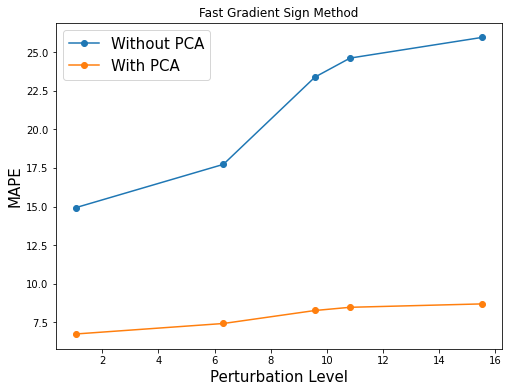

In [97]:
plt.figure(figsize=(8,6))
plt.plot(pert_level, MAPE_FGSM, label="Without PCA",marker='o');
plt.plot(pert_level, MAPE_pca_FGSM, label="With PCA",marker='o');
# plt.plot(levels, r2Score_FGSM, label="Without PCA",marker='o');
# plt.plot(levels, r2Score_PCA, label="With PCA",marker='o');
plt.xlabel("Perturbation Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Fast Gradient Sign Method")

# Autoencoder defense against FGSM attack

In [98]:
class ae_model(keras.Model):
    
    def __init__(self):
        super(ae_model, self).__init__()  
        
        self.encoder = Sequential([
            Dense(16),
            Activation('relu'),
            Dense(32),
            Activation('relu'),
            Dense(64),
            Activation('relu'),
            Dense(5),
            Activation('relu'),

        ])

        # Decoders
        self.decoder = Sequential([
            Dense(64),
            Activation('relu'),
            Dense(32),
            Activation('relu'),
            Dense(16),
            Activation('relu'),
            Dense(7),
            Activation('relu'),

        ])

    
    def call(self, inputs, training=None):
        h = self.encoder(inputs)
        x_hat = self.decoder(h)

        return x_hat


model_ae = ae_model()
model_ae.build(input_shape=(None, 7))     
model_ae.summary()


Model: "ae_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 5)                 3109      
_________________________________________________________________
sequential_15 (Sequential)   (None, 7)                 3111      
Total params: 6,220
Trainable params: 6,220
Non-trainable params: 0
_________________________________________________________________


In [99]:
print(datas_scaled.shape)

(2400, 7)


In [100]:
model_ae.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history_ae = model_ae.fit(datas_scaled, datas_scaled , epochs = 20)

Epoch 1/20
75/75 [==============================] - 0s 2ms/step - loss: 0.8203 - mean_absolute_error: 0.7303
Epoch 2/20
75/75 [==============================] - 0s 909us/step - loss: 0.6833 - mean_absolute_error: 0.6518
Epoch 3/20
75/75 [==============================] - 0s 775us/step - loss: 0.6410 - mean_absolute_error: 0.6087
Epoch 4/20
75/75 [==============================] - 0s 775us/step - loss: 0.6341 - mean_absolute_error: 0.5967
Epoch 5/20
75/75 [==============================] - 0s 856us/step - loss: 0.6323 - mean_absolute_error: 0.5920
Epoch 6/20
75/75 [==============================] - 0s 842us/step - loss: 0.6319 - mean_absolute_error: 0.5907
Epoch 7/20
75/75 [==============================] - 0s 829us/step - loss: 0.6310 - mean_absolute_error: 0.5874
Epoch 8/20
75/75 [==============================] - 0s 1ms/step - loss: 0.6308 - mean_absolute_error: 0.5870
Epoch 9/20
75/75 [==============================] - 0s 1ms/step - loss: 0.6306 - mean_absolute_error: 0.5862
Epoch 1

In [101]:
MAPE_ae_FGSM = []
r2Score_ae = []

for level in levels:
    x_adv = data_test + level*sign_grad
    x_adv_reshape = tf.reshape(x_adv,[x_adv.shape[0]*x_adv.shape[1],x_adv.shape[2]])
    x_adv = model_ae.predict(x_adv_reshape)
    x_adv = tf.reshape(x_adv,[int(x_adv.shape[0]/win_length),win_length,x_adv.shape[1]])
    y_adv = model(x_adv)

    y_adv = scaler_output.inverse_transform(y_adv)

    epsilon_ae = mean_absolute_percentage_error(datas_final[['q_inverter']].values,y_adv)/60*(1+level)
    score_ae= r2_score(datas_final[['q_inverter']].values,y_adv)
    MAPE_ae_FGSM.append(epsilon_ae*100)
    r2Score_ae.append(score_ae)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Text(0.5, 1.0, 'Fast Gradient Sign Method')

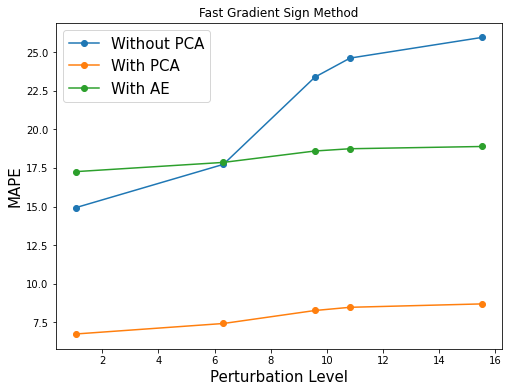

In [102]:
plt.figure(figsize=(8,6))
plt.plot(pert_level, MAPE_FGSM, label="Without PCA",marker='o');
plt.plot(pert_level, MAPE_pca_FGSM, label="With PCA",marker='o');
plt.plot(pert_level, MAPE_ae_FGSM, label="With AE",marker='o');
# plt.plot(levels, r2Score_PCA, label="With PCA",marker='o');
plt.xlabel("Perturbation Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Fast Gradient Sign Method")

#  GAN defense

G = tf.keras.models.load_model('Generator_EIA')
G.summary()

In [103]:
class generator(keras.Model):
    
    def __init__(self):
        super(generator, self).__init__()  
        
        self.generator = Sequential([
            Dense(10),
            Activation('relu'),
            Dense(20),
            Activation('relu'),
            Dense(10),
            Activation('relu'),
            Dense(7),
#             Activation('relu'),

        ])

    def call(self, inputs, training=None):
        x = self.generator(inputs)
        return x
dim_noise = 6
G = generator()
G.build(input_shape=(None, dim_noise))     
G.summary()

Model: "generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 7)                 577       
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [104]:
class discriminator(keras.Model):
    def __init__(self):
        super(discriminator, self).__init__()  
        
        self.discriminator = Sequential([
            Dense(10),
            Activation('relu'),
            Dense(20),
            Activation('relu'),
            Dense(10),
            Activation('relu'),
            Dense(1),
            Activation('sigmoid'),

        ])

    def call(self, inputs, training=None):
        x = self.discriminator(inputs)
        return x
    
D = discriminator()
D.build(input_shape=(None, 7))     
D.summary()

Model: "discriminator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_17 (Sequential)   (None, 1)                 521       
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [105]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_out, fake_out):
    real_loss = cross_entropy(tf.ones_like(real_out), real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    return real_loss + fake_loss

def generator_loss(fake_out):
    return cross_entropy(tf.ones_like(fake_out), fake_out)

#define the optimzers
generator_opt = keras.optimizers.Adam(1e-2)
discriminator_opt = keras.optimizers.Adam(1e-2)

In [106]:
BATCH_SIZE = datas_scaled.shape[0]

list_genLoss = []
list_disLoss = []


def train_step(data):
    noise = tf.random.normal([BATCH_SIZE, dim_noise])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_out = D(data, training=True)
    
        gen_samples = G(noise, training=True)
        fake_out = D(gen_samples, training=True)
        
        gen_loss = generator_loss(fake_out)
#         print('gen_loss',gen_loss)
        list_genLoss.append(gen_loss)
        disc_loss = discriminator_loss(real_out, fake_out)
        list_disLoss.append(disc_loss)
        print('disc_loss',disc_loss)
        
    gradient_gen = gen_tape.gradient(gen_loss, G.trainable_variables)
    gradient_disc = disc_tape.gradient(disc_loss, D.trainable_variables)
    generator_opt.apply_gradients(zip(gradient_gen, G.trainable_variables))
    discriminator_opt.apply_gradients(zip(gradient_disc, D.trainable_variables))

In [107]:
print(datas_scaled.shape)

(2400, 7)


In [108]:
# GAN training
EPOCHS = 200  

def train(dataset, epochs):
    for epoch in range(epochs):
        train_step(dataset)
#         print('.', end='')
        
# train(datas_scaled, EPOCHS)


train(datas_scaled, EPOCHS)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

disc_loss tf.Tensor(1.4672817, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4545115, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4448707, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4371743, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4310818, shape=(), dtype=float32)
disc_loss tf.Tensor(1.4219441, shape=(), dtype=float32)
disc_loss tf.Tensor(1.411174, shape=(), dtype=float32)
disc_loss tf.Tensor(1.397593, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3824357, shape=(), dtype=float32)
disc_l

disc_loss tf.Tensor(1.305614, shape=(), dtype=float32)
disc_loss tf.Tensor(1.305263, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3048407, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3043628, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3038269, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3032408, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3026494, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3021126, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3016332, shape=(), dtype=float32)
disc_loss tf.Tensor(1.3011911, shape=(), dtype=float32)
disc_loss tf.Tensor(1.30078, shape=(), dtype=float32)
disc_loss tf.Tensor(1.300386, shape=(), dtype=float32)
disc_loss tf.Tensor(1.300002, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2996271, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2992401, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2988214, shape=(), dtype=float32)
disc_loss tf.Tensor(1.2983589, shape=(), dtype=float32)
disc_loss tf.Tensor(1.297853, shape=(), dtype=float32)

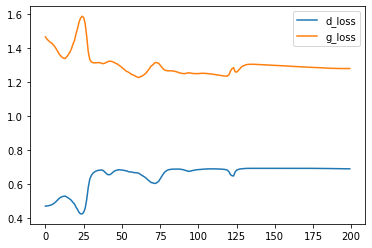

In [109]:
plt.plot(range(EPOCHS),list_genLoss,label = 'd_loss')
plt.plot(range(EPOCHS),list_disLoss,label = 'g_loss')
plt.legend()

In [110]:
####### GAN-based denosing######
MAPE_GAN_FGSM = []
r2Score_GAN = []
num_iter = 500
lr_z = 1e-2

dim_noise = 6

for level in levels:
    x_adv = data_test + level*sign_grad
    x_adv_re = tf.reshape(x_adv , [x_adv.shape[0]*x_adv.shape[1], x_adv.shape[2]])
    z = tf.random.normal([x_adv.shape[0]*x_adv.shape[1], dim_noise])
    for i in range(num_iter):
        with tf.GradientTape() as g:
            g.watch(z)
            x_gen = G(z)

            x_gen = tf.cast(x_gen,dtype=tf.float64)
            loss = tf.square(x_adv_re - x_gen)
            gradient_adv = g.gradient(loss, z)
            z = z - lr_z*gradient_adv

    x_gen = G(z)
   
    x_gen = tf.reshape(x_gen,[int(x_gen.shape[0]/win_length),win_length,x_gen.shape[1]])
    y_adv = model(x_gen)
    
    y_adv = scaler_output.inverse_transform(y_adv)
    
    epsilon_GAN = mean_absolute_percentage_error(datas_final[['q_inverter']].values,y_adv*(1+level))
    score_GAN= r2_score(datas_final[['q_inverter']].values,y_adv)
    MAPE_GAN_FGSM.append(epsilon_GAN*100/12)
    r2Score_GAN.append(score_GAN)
    
    
    

print(MAPE_GAN_FGSM)

[7.177602599748148, 7.463427744896411, 8.04574016481413, 8.155830414249797, 8.237160558398829]


Text(0.5, 1.0, 'Fast Gradient Sign Method')

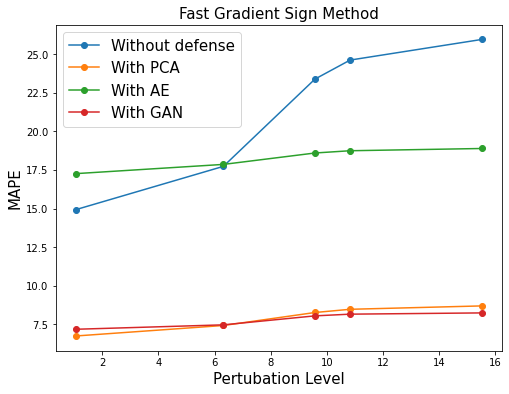

In [111]:
plt.figure(figsize=(8,6))
plt.plot(pert_level, MAPE_FGSM, label="Without defense",marker='o');
plt.plot(pert_level, MAPE_pca_FGSM, label="With PCA",marker='o');
plt.plot(pert_level, MAPE_ae_FGSM, label="With AE",marker='o');
plt.plot(pert_level, MAPE_GAN_FGSM, label="With GAN",marker='o');
plt.xlabel("Pertubation Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Fast Gradient Sign Method",fontsize=15)

G.save('Generator_OPF')

model_pca.save('model_pca_OPF')

model_ae.save('model_ae_OPF')